In [1]:
import os
import zipfile

# Make a kaggle folder and move the json file there
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Give the API key file proper permissions
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset

Dataset URL: https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset
License(s): unknown
 97% 764M/787M [00:08<00:00, 264MB/s]
100% 787M/787M [00:08<00:00, 98.5MB/s]


In [3]:
import zipfile
with zipfile.ZipFile("kaggle-cat-vs-dog-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("cat_vs_dog")

# CREATE TRAINING AND TESTING SET

In [4]:
import os

# Where your current cat/dog images are
original_dataset_dir = '/content/cat_vs_dog/kagglecatsanddogs_3367a/PetImages'

# New base folder to hold train and validation
base_dir = '/content/cats_and_dogs_filtered'
os.makedirs(base_dir, exist_ok=True)

# Create train and validation folders inside it
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Create Cat and Dog folders inside both train and validation
for folder in [train_dir, val_dir]:
    os.makedirs(os.path.join(folder, 'Cat'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'Dog'), exist_ok=True)

In [5]:
import shutil
import random

# This function splits images for either 'Cat' or 'Dog'
def split_data(class_name):
    src = os.path.join(original_dataset_dir, class_name)

    # Get all file names ending with .jpg
    files = [f for f in os.listdir(src) if f.lower().endswith('.jpg')]

    # Shuffle to randomize selection
    random.shuffle(files)

    # 80% for training
    split_index = int(0.8 * len(files))
    train_files = files[:split_index]
    val_files = files[split_index:]

    # Copy 80% to train folder
    for f in train_files:
        try:
            shutil.copy(os.path.join(src, f), os.path.join(train_dir, class_name, f))
        except:
            pass  # skip broken images

    # Copy 20% to validation folder
    for f in val_files:
        try:
            shutil.copy(os.path.join(src, f), os.path.join(val_dir, class_name, f))
        except:
            pass

# Call function for both classes
split_data('Cat')
split_data('Dog')

In [6]:
# LIBRIES
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_data_gen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
)

In [ ]:
val_data_gen = ImageDataGenerator(
    rescale=1/255
)

In [ ]:
train_gen = train_data_gen.flow_from_directory(
    train_dir,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'binary',


)

val_gen = val_data_gen.flow_from_directory(
    val_dir,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'binary',

)

Found 19967 images belonging to 2 classes.
Found 4992 images belonging to 2 classes.


In [ ]:
import numpy as np

unique, counts = np.unique(train_gen.classes, return_counts=True)
print("Train class distribution:", dict(zip(unique, counts)))

unique_val, counts_val = np.unique(val_gen.classes, return_counts=True)
print("Validation class distribution:", dict(zip(unique_val, counts_val)))

Train class distribution: {np.int32(0): np.int64(9992), np.int32(1): np.int64(9975)}
Validation class distribution: {np.int32(0): np.int64(2498), np.int32(1): np.int64(2494)}


In [ ]:
# One batch of training data
train_images, train_labels = next(train_gen)

# One batch of validation data
val_images, val_labels = next(val_gen)

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, labels, title, class_names=["Cat", "Dog"]):
    plt.figure(figsize=(12, 6))
    for i in range(8):  # show first 8 images
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        label = class_names[int(labels[i])]
        plt.title(label)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

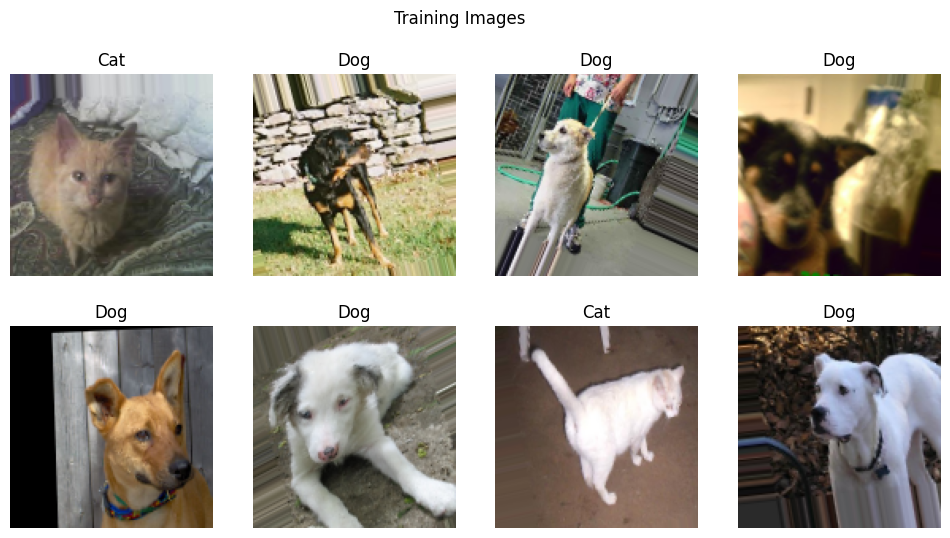

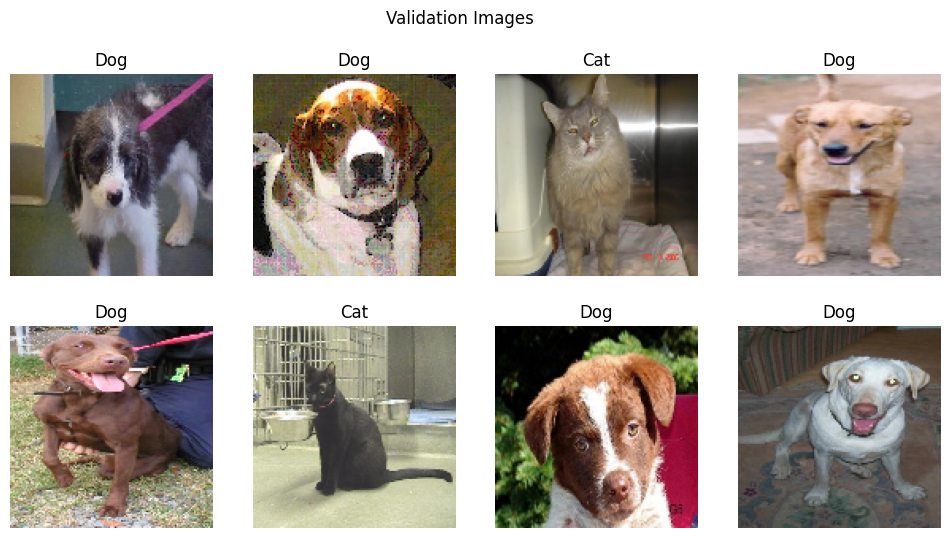

In [ ]:
show_images(train_images, train_labels, title="Training Images")
show_images(val_images, val_labels, title="Validation Images")

# BUILD CNN MODEL

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

# CONV1
model.add(Conv2D(32,kernel_size=(3,3),strides=(2,2),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV2
model.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV3
model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# FLATTEN
model.add(GlobalAveragePooling2D())

# FULLY CONNECTED LAYERS
model.add(Dense(128,activation='selu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64,activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid',kernel_regularizer=l2(0.01)))

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 127, 127, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,977 (464.75 KB)

 Trainable params: 118,529 (463.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.001,
    patience = 5,
    mode='auto',
    restore_best_weights=True
)

In [ ]:
history = model.fit(train_gen,epochs=20,validation_data=val_gen,callbacks=early_stop)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 140s 213ms/step - accuracy: 0.5565 - loss: 1.9218 - val_accuracy: 0.6250 - val_loss: 0.9765
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 127s 204ms/step - accuracy: 0.6339 - loss: 0.8750 - val_accuracy: 0.6669 - val_loss: 0.6544
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 142s 204ms/step - accuracy: 0.6735 - loss: 0.6438 - val_accuracy: 0.6166 - val_loss: 0.7136
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - accuracy: 0.6973 - loss: 0.5986 - val_accuracy: 0.7051 - val_loss: 0.5786
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 128s 204ms/step - accuracy: 0.7202 - loss: 0.5621 - val_accuracy: 0.6839 - val_loss: 0.6254
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - accuracy: 0.7386 - loss: 0.5436 - val_accuracy: 0.7486 - val_loss: 0.5237
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 127s 204ms/step - accuracy: 0.7427 - loss: 0.5349 - val_accuracy: 0.7023 - val_loss: 0.6029
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 126s 203ms/step - accuracy: 0.7478 -

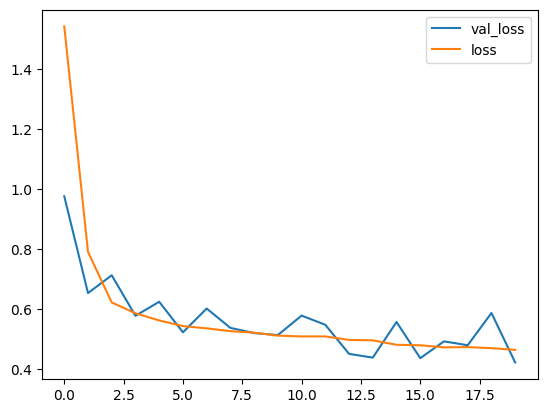

In [ ]:
plt.plot(history.history['val_loss'],label='val_loss')
plt.plot(history.history['loss'],label='loss')
plt.legend()
plt.show()

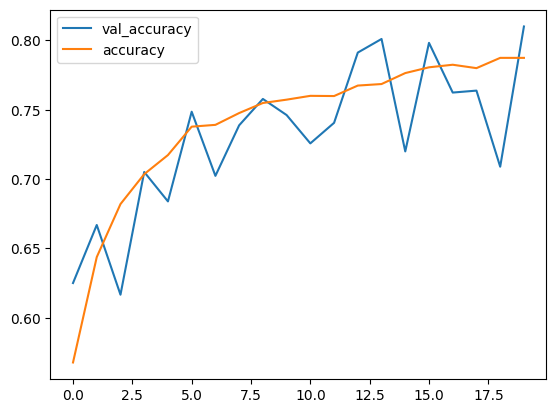

In [ ]:
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()
plt.show()

# TRANSFER LEARNING BY FEATURE EXTRACTION

In [ ]:
train_data_gen = ImageDataGenerator(
    rescale=1/255
)
val_data_gen = ImageDataGenerator(
    rescale=1/255
)

In [ ]:
train_gen = train_data_gen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary',


)

val_gen = val_data_gen.flow_from_directory(
    val_dir,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary',

)

Found 19967 images belonging to 2 classes.
Found 4992 images belonging to 2 classes.


In [ ]:
# One batch of training data
train_images, train_labels = next(train_gen)

# One batch of validation data
val_images, val_labels = next(val_gen)

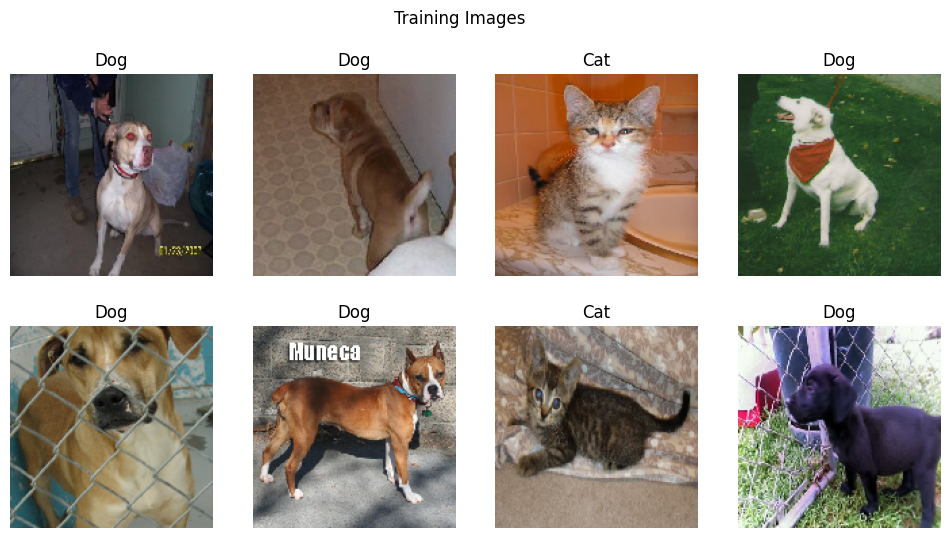

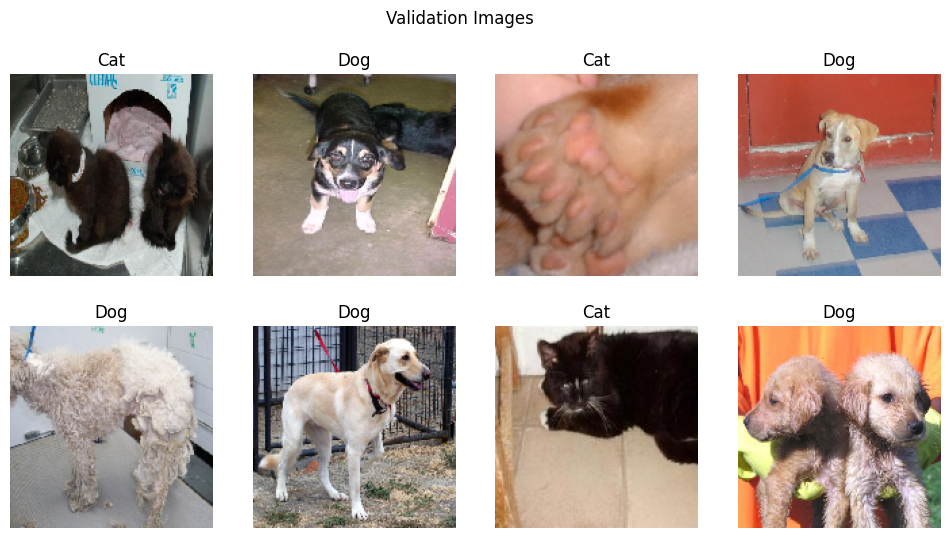

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, labels, title, class_names=["Cat", "Dog"]):
    plt.figure(figsize=(12, 6))
    for i in range(8):  # show first 8 images
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        label = class_names[int(labels[i])]
        plt.title(label)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(train_images, train_labels, title="Training Images")
show_images(val_images, val_labels, title="Validation Images")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping

from keras.applications.vgg16 import VGG16

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape = (150,150,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Sequential()

model.add(conv_base)

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,771,713 (60.16 MB)

 Trainable params: 15,771,713 (60.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
conv_base.trainable = False

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.001,
                           patience=5,
                           restore_best_weights=True)

In [ ]:
history = model.fit(train_gen,epochs=10,validation_data=val_gen,callbacks=early_stop)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


431/624 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.8343 - loss: 0.3488

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


624/624 ━━━━━━━━━━━━━━━━━━━━ 93s 134ms/step - accuracy: 0.8483 - loss: 0.3253 - val_accuracy: 0.9137 - val_loss: 0.2041
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 84s 135ms/step - accuracy: 0.9153 - loss: 0.1984 - val_accuracy: 0.8962 - val_loss: 0.2362
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step - accuracy: 0.9315 - loss: 0.1644 - val_accuracy: 0.9193 - val_loss: 0.1946
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - accuracy: 0.9419 - loss: 0.1411 - val_accuracy: 0.9099 - val_loss: 0.2390
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - accuracy: 0.9513 - loss: 0.1200 - val_accuracy: 0.9201 - val_loss: 0.2077
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step - accuracy: 0.9544 - loss: 0.1076 - val_accuracy: 0.8998 - val_loss: 0.2807
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - accuracy: 0.9684 - loss: 0.0800 - val_accuracy: 0.9143 - val_loss: 0.2402
Epoch 8/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 139s 127ms/step - accuracy: 0.9765 - loss: 0.0653 - va

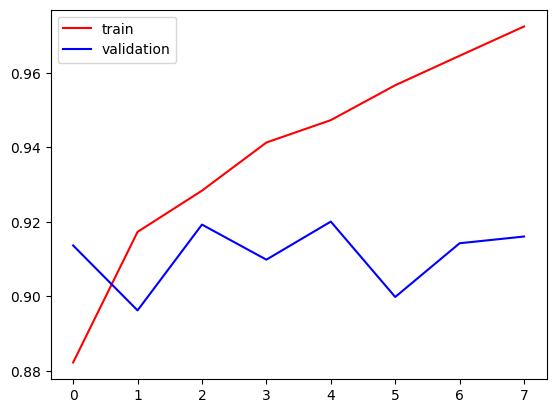

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

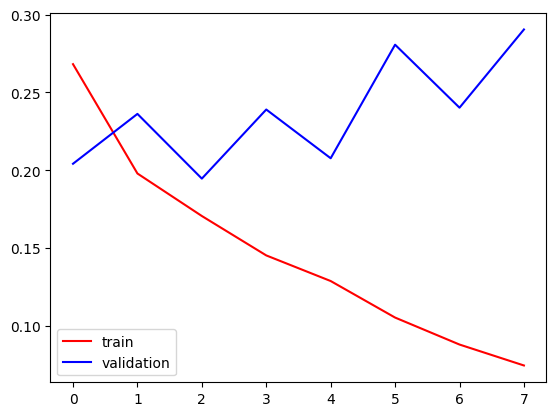

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
imgs,labels = next(val_gen)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(imgs)
import numpy as np
y_pred = np.where(y_pred.ravel()>0.5,1,0)
print('accuracy_score :',accuracy_score(labels,y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


0.90625

In [ ]:
import numpy as np
y_pred = np.where(y_pred.ravel()>0.5,1,0)

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0])

In [ ]:
imgs.shape,labels.shape

((32, 150, 150, 3), (32,))

# DATA AUGMENTATION WITH TRANSFER LEARNING

In [ ]:
train_data_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2,fill_mode='nearest',
    horizontal_flip=True
)
val_data_gen = ImageDataGenerator(
    rescale=1/255
)

In [ ]:
train_gen = train_data_gen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary',


)

val_gen = val_data_gen.flow_from_directory(
    val_dir,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary',

)

Found 19967 images belonging to 2 classes.
Found 4992 images belonging to 2 classes.


In [ ]:
# One batch of training data
train_images, train_labels = next(train_gen)

# One batch of validation data
val_images, val_labels = next(val_gen)

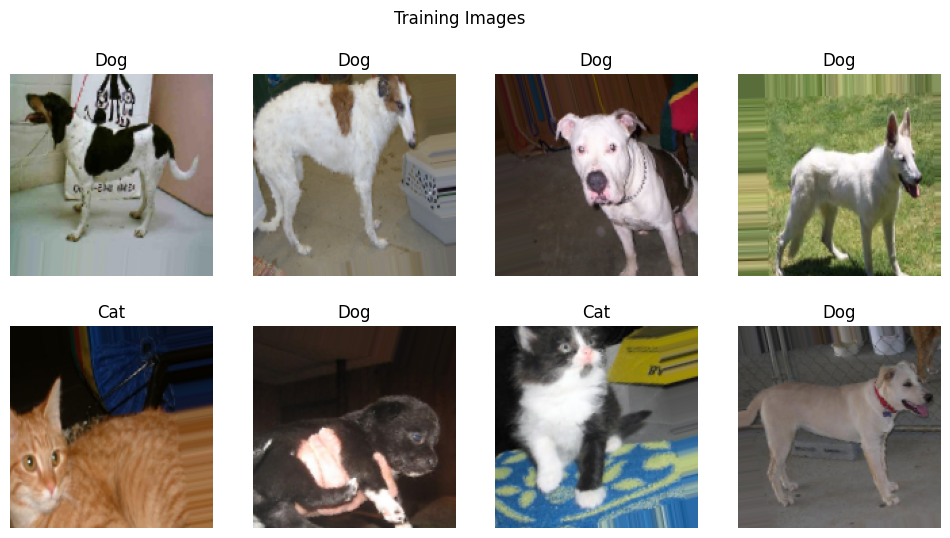

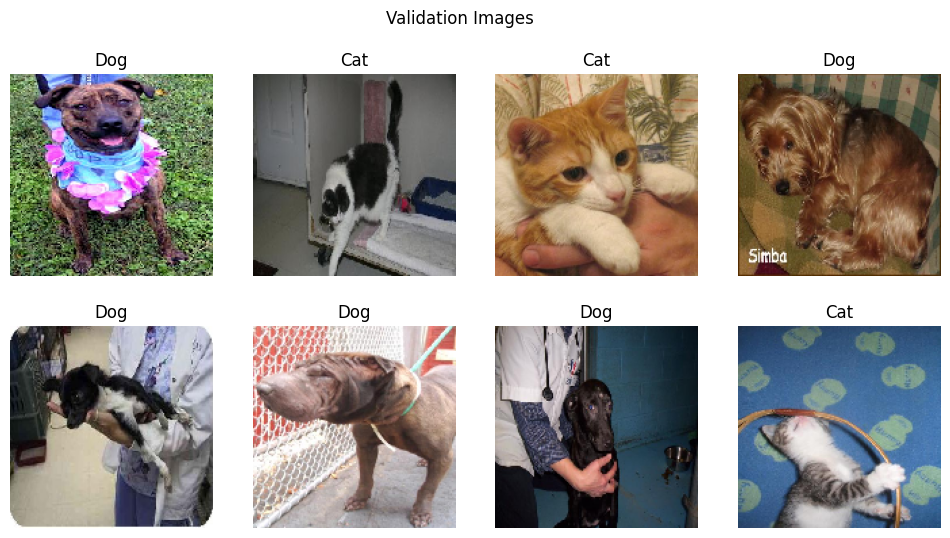

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, labels, title, class_names=["Cat", "Dog"]):
    plt.figure(figsize=(12, 6))
    for i in range(8):  # show first 8 images
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        label = class_names[int(labels[i])]
        plt.title(label)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(train_images, train_labels, title="Training Images")
show_images(val_images, val_labels, title="Validation Images")

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,771,713 (60.16 MB)

 Trainable params: 15,771,713 (60.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
conv_base.trainable=False

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           min_delta=0.01,
                           restore_best_weights=False)

In [ ]:
history = model.fit(train_gen,epochs=10,validation_data=val_gen,callbacks=early_stop)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
424/624 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - accuracy: 0.7863 - loss: 0.4411

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


624/624 ━━━━━━━━━━━━━━━━━━━━ 165s 260ms/step - accuracy: 0.8017 - loss: 0.4163 - val_accuracy: 0.9038 - val_loss: 0.2197
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 165s 265ms/step - accuracy: 0.8665 - loss: 0.3048 - val_accuracy: 0.9077 - val_loss: 0.2135
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 161s 258ms/step - accuracy: 0.8677 - loss: 0.2964 - val_accuracy: 0.9131 - val_loss: 0.1999
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 164s 263ms/step - accuracy: 0.8741 - loss: 0.2851 - val_accuracy: 0.9167 - val_loss: 0.1960
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 161s 258ms/step - accuracy: 0.8815 - loss: 0.2708 - val_accuracy: 0.8984 - val_loss: 0.2270
Epoch 6/10
243/624 ━━━━━━━━━━━━━━━━━━━━ 1:29 234ms/step - accuracy: 0.8817 - loss: 0.2766

KeyboardInterrupt: 

# TRANSFER LEARNING BY FINE TUNE

In [29]:
train_data_gen = ImageDataGenerator(
    rescale=1/255
)
val_data_gen = ImageDataGenerator(
    rescale=1/255
)

In [30]:
train_gen = train_data_gen.flow_from_directory(
    train_dir,target_size=(150,150),
    class_mode='binary',
    batch_size=32
)
val_gen = val_data_gen.flow_from_directory(
    val_dir,target_size=(150,150),
    class_mode='binary',
    batch_size=32
)


Found 19967 images belonging to 2 classes.
Found 4992 images belonging to 2 classes.


In [31]:
from keras.applications.vgg16 import VGG16

In [32]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)

)

In [33]:
conv_base.trainable = True

set_trainable = False
for layer  in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
  print(layer.name,layer.trainable)


input_layer_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [34]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [35]:
model =  Sequential()
model.add(conv_base)
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


In [36]:
model.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['accuracy'])

In [37]:
early_stop = EarlyStopping(
    monitor='val_loss',patience=5,
    min_delta=0.01,
    restore_best_weights=True
)

In [38]:
history = model.fit(train_gen,epochs=10,validation_data=val_gen,callbacks=early_stop)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


571/624 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.7260 - loss: 0.5040

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


624/624 ━━━━━━━━━━━━━━━━━━━━ 100s 155ms/step - accuracy: 0.7368 - loss: 0.4873 - val_accuracy: 0.9339 - val_loss: 0.1675
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.9476 - loss: 0.1353 - val_accuracy: 0.9441 - val_loss: 0.1485
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 94s 151ms/step - accuracy: 0.9649 - loss: 0.0949 - val_accuracy: 0.9271 - val_loss: 0.1843
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 99s 158ms/step - accuracy: 0.9766 - loss: 0.0651 - val_accuracy: 0.9445 - val_loss: 0.1455
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 94s 151ms/step - accuracy: 0.9804 - loss: 0.0548 - val_accuracy: 0.9163 - val_loss: 0.2847
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 147s 159ms/step - accuracy: 0.9852 - loss: 0.0413 - val_accuracy: 0.9499 - val_loss: 0.1865
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 95s 151ms/step - accuracy: 0.9933 - loss: 0.0223 - val_accuracy: 0.9389 - val_loss: 0.3291


# WITH THE HELP OF TRANSFER LEARNING, OUR VALIDATION ACCURACY REACHED 94% AND BINARY CROSS-ENTROPY LOSS DROPPED TO 14. THIS IS A SIGNIFICANT IMPROVEMENT, AS IN OUR PREVIOUS NOTEBOOK, EVEN AFTER EXPERIMENTING WITH MANY ARCHITECTURES, WE COULD ONLY ACHIEVE 83% ACCURACY AND A LOSS OF 40.

NameError: name 'history' is not defined